##Dataset properties##

Total number of images: 82213.

Training set size: 61488 images (one fruit or vegetable per image).

Test set size: 20622 images (one fruit or vegetable per image).

Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)

Number of classes: 120 (fruits and vegetables).

Image size: 100x100 pixels.

Filename format: image_index_100.jpg (e.g. 32_100.jpg) or r_image_index_100.jpg (e.g. r_32_100.jpg) or r2_image_index_100.jpg or r3_image_index_100.jpg. "r" stands for rotated fruit. "r2" means that the fruit was rotated around the 3rd axis. "100" comes from image size (100x100 pixels).

Different varieties of the same fruit (apple for instance) are stored as belonging to different classes.

In [0]:
import tensorflow

In [0]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import glob
import os

# imports for array-handling and plotting
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})


## Import Fruits 360 Data Set from Github ##

In [0]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git
!ls
!cd Fruit-Images-Dataset
!ls

fatal: destination path 'Fruit-Images-Dataset' already exists and is not an empty directory.
Fruit-Images-Dataset  sample_data
Fruit-Images-Dataset  sample_data


In [0]:
print(os.listdir("Fruit-Images-Dataset"))

['LICENSE', 'papers', 'src', 'test-multiple_fruits', '.git', 'Test', 'Training', 'readme.md']


#### Image Preprocessing ####

In [0]:
# Setting Image Directories for Training, Validation and Testing Multiple Fruits
train_dir='Fruit-Images-Dataset/Training/*'
validation_dir='Fruit-Images-Dataset/Test/*'
testPred_dir='Fruit-Images-Dataset/test-multiple_fruits/*'

#### Extracting Training Images & Labels ####

Glob.glob is used for the respective training directory in order to extract the jpg images, read the respective colors, resize them to 64 x 64, and convert the colors to RGB rendering an input shape = (64,64,3). As such, both images and labels were then appended into their respective arrays: **training_fruit_img** and **training_label**.

In [0]:
training_fruit_img = []
training_label = []
for dir_path in glob.glob(train_dir):
    img_label = dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (64, 64))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        training_fruit_img.append(image)
        training_label.append(img_label)
        
training_fruit_img = np.array(training_fruit_img)
training_label = np.array(training_label)

Just to make sure how many categories are there in the given labels, we use label_to_id and id_to_label. As we can see, there are 120 classes as expected. We will use this for the one hot representation later as well as softmax layer.

In [0]:
label_to_id = {v:k for k,v in enumerate(np.unique(training_label)) }
id_to_label = {v:k for k,v in label_to_id.items() }

In [0]:
# Id to Labels to Enumerate how many labels we need to one hot encoding on
id_to_label

{0: 'Apple Braeburn',
 1: 'Apple Crimson Snow',
 2: 'Apple Golden 1',
 3: 'Apple Golden 2',
 4: 'Apple Golden 3',
 5: 'Apple Granny Smith',
 6: 'Apple Pink Lady',
 7: 'Apple Red 1',
 8: 'Apple Red 2',
 9: 'Apple Red 3',
 10: 'Apple Red Delicious',
 11: 'Apple Red Yellow 1',
 12: 'Apple Red Yellow 2',
 13: 'Apricot',
 14: 'Avocado',
 15: 'Avocado ripe',
 16: 'Banana',
 17: 'Banana Lady Finger',
 18: 'Banana Red',
 19: 'Beetroot',
 20: 'Blueberry',
 21: 'Cactus fruit',
 22: 'Cantaloupe 1',
 23: 'Cantaloupe 2',
 24: 'Carambula',
 25: 'Cauliflower',
 26: 'Cherry 1',
 27: 'Cherry 2',
 28: 'Cherry Rainier',
 29: 'Cherry Wax Black',
 30: 'Cherry Wax Red',
 31: 'Cherry Wax Yellow',
 32: 'Chestnut',
 33: 'Clementine',
 34: 'Cocos',
 35: 'Dates',
 36: 'Eggplant',
 37: 'Ginger Root',
 38: 'Granadilla',
 39: 'Grape Blue',
 40: 'Grape Pink',
 41: 'Grape White',
 42: 'Grape White 2',
 43: 'Grape White 3',
 44: 'Grape White 4',
 45: 'Grapefruit Pink',
 46: 'Grapefruit White',
 47: 'Guava',
 48: 'Haze

In [0]:
training_label_id = np.array([label_to_id[i] for i in training_label])
training_label_id

array([66, 66, 66, ..., 90, 90, 90])

In [0]:
#training_label = np.unique(training_label)
#training_label

We ensure that the training_fruit_img and training_label_id shapes are at par with each other.

In [0]:
training_fruit_img.shape,training_label_id.shape

((61488, 64, 64, 3), (61488,))

#### Extracting Validation Images & Labels ####

Glob.glob is used for the respective training directory in order to extract the jpg images, read the respective colors, resize them to 64 x 64, and convert the colors to RGB rendering an input shape = (64,64,3). As such, both images and labels were then appended into their respective arrays: **validation_fruit_img** and **validation_label**.

In [0]:
validation_fruit_img=[]
validation_label =[]
for dir_path in glob.glob(validation_dir):
    img_label = dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (64, 64))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        validation_fruit_img.append(image)
        validation_label.append(img_label)
validation_fruit_img = np.array(validation_fruit_img)
validation_label = np.array(validation_label)

In [0]:
#validation_label = np.unique(validation_label)
#validation_label

In [0]:
validation_label_id = np.array([label_to_id[i] for i in validation_label])

We ensure that the validation_fruit_img and validation_label_id shapes are at par with each other.

In [0]:
validation_fruit_img.shape,validation_label_id.shape

((20622, 64, 64, 3), (20622,))

#### More Image Preprocessing ####

We then define the training and testing sets derived from both the training and validation image and labels. 

In [0]:
X_train,X_test = training_fruit_img,validation_fruit_img
Y_train,Y_test = training_label_id,validation_label_id

Data Augmentation for Normalization and Reshape as well as One Hot Encoding is done in the following steps

In [0]:
X_train = X_train/255
X_test = X_test/255

#X_flat_train = X_train.reshape(X_train.shape[0],64*64*3)
#X_flat_test = X_test.reshape(X_test.shape[0],64*64*3)

In [0]:
#One Hot Encode the Output
Y_train = to_categorical(Y_train, 120)
Y_test = to_categorical(Y_test, 120)

#print('Original Sizes:', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
#print('Flattened:', X_flat_train.shape, X_flat_test.shape)

In [0]:
print(X_train[1200].shape)
plt.imshow(X_train[1200])
plt.show()

(64, 64, 3)


## Convolutional Layers ##

Convolutional Models are as shown below. 


*   conf_model is derived from the configuration # 1 of the paper
*   my_model1 is the first model I have created
*   my_model2 is the second model I have created


All models will be fitted using batch_size of 300.


In [0]:
def conf_model():
  model=Sequential()
  model.add(Conv2D(16,(5,5),input_shape=(64,64,3),activation='relu'))
  model.add(Conv2D(32,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(Conv2D(64,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(Conv2D(128,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dense(120,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',
                metrics=['accuracy'])
  model.summary()

  return model
  
def my_model1():
  model=Sequential()
  model.add(Conv2D(16,(3,3),input_shape=(64,64,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(Conv2D(128,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(120,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',
                metrics=['accuracy'])
  model.summary()

  return model

def my_model2():
  model=Sequential()
  model.add(Conv2D(16,(5,5),input_shape=(64,64,3),activation='relu'))
  model.add(Conv2D(32,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(120,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()

  return model

def metrics_plot(history):
  # plotting the metrics
  fig = plt.figure()
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  pyplot.title('Classification Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  pyplot.title('Cross Entropy Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

  return fig

def eval_model(model):
  score = model.evaluate(X_test, Y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1]*100) 

####  Saving/ Loading Model to Disk ####

In [0]:
# Save model to disk
#def save_model(model):
#  model_json = model.to_json()
#  name_json = str(model) + ".json"
#  with open(name_json, "w") as json_file:
#      json_file.write(model_json)
#  name_weight = str(model) + ".h5"
#  model.save_weights(name_weight)
#  print("CNN model saved to disk")

In [0]:
# Load model from disk
#def load_model(model):
#  name_json = str(model) + ".json"
#  json_file = open(name_json, 'r')
#  loaded_model_json = json_file.read()
#  json_file.close()
#  loaded_model = model_from_json(loaded_model_json)
#  name_weight = str(model) + ".h5"
#  loaded_model.load_weights(name_weight)
#  print("CNN model loaded from disk")

#### BASELINE MODEL ####

In [0]:
# Make Convolutional Neural Network
baseline_model = conf_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        12832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0

In [0]:
# Compile and fit
baseline_history = baseline_model.fit(X_train,
          Y_train,
          batch_size=200,
          epochs=10,
          verbose=1,
          validation_data = (X_test,Y_test)
         )

Epoch 1/10
308/308 [==============================] - 9s 28ms/step - loss: 0.8403 - accuracy: 0.7800 - val_loss: 0.3790 - val_accuracy: 0.9081
Epoch 2/10
308/308 [==============================] - 8s 27ms/step - loss: 0.0770 - accuracy: 0.9788 - val_loss: 0.1678 - val_accuracy: 0.9502
Epoch 3/10
308/308 [==============================] - 8s 27ms/step - loss: 0.0152 - accuracy: 0.9957 - val_loss: 0.2022 - val_accuracy: 0.9545
Epoch 4/10
308/308 [==============================] - 8s 27ms/step - loss: 0.0427 - accuracy: 0.9873 - val_loss: 0.2229 - val_accuracy: 0.9483
Epoch 5/10
308/308 [==============================] - 8s 27ms/step - loss: 0.0410 - accuracy: 0.9880 - val_loss: 0.1900 - val_accuracy: 0.9572
Epoch 6/10
308/308 [==============================] - 8s 27ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.1383 - val_accuracy: 0.9715
Epoch 7/10
308/308 [==============================] - 8s 27ms/step - loss: 6.0867e-05 - accuracy: 1.0000 - val_loss: 0.1416 - val_accuracy: 0.

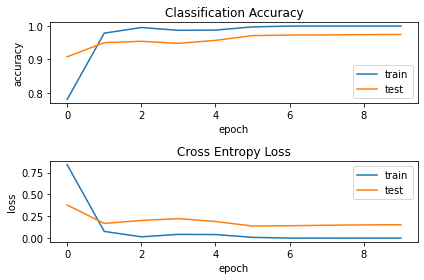

In [0]:
metrics_plot(baseline_history)

In [0]:
eval_model(baseline_model)

Test loss: 0.15414974093437195
Test accuracy: 97.48327136039734


#### Baseline Model Test Predictions ####

In [0]:
y_pred_baseline = baseline_model.predict(X_test)

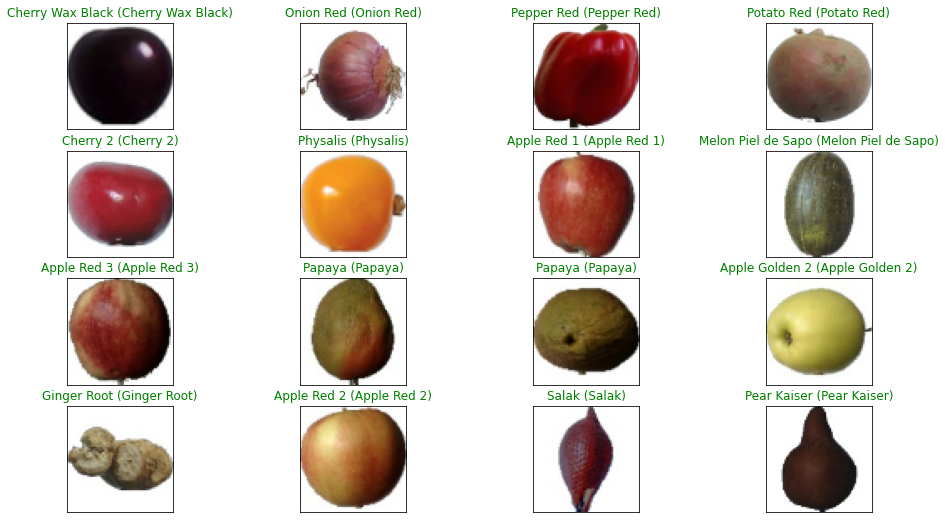

In [0]:
training_label1 = np.unique(training_label)
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred_baseline[idx])
    true_idx = np.argmax(Y_test[idx])
    ax.set_title("{} ({})".format(training_label1[pred_idx], training_label1[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

fig

#### CNN MODEL #1 ####

In [0]:
# Make Convolutional Neural Network
cnn_model_1 = my_model1()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        9280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 128)        

In [0]:
# Compile and fit
cnn_model_1_history = cnn_model_1.fit(X_train,
          Y_train,
          batch_size=200,
          epochs=10,
          verbose=1,
          validation_data = (X_test,Y_test)
         )

Epoch 1/10
308/308 [==============================] - 6s 20ms/step - loss: 1.3940 - accuracy: 0.6302 - val_loss: 0.2276 - val_accuracy: 0.9309
Epoch 2/10
308/308 [==============================] - 6s 19ms/step - loss: 0.1302 - accuracy: 0.9570 - val_loss: 0.1103 - val_accuracy: 0.9630
Epoch 3/10
308/308 [==============================] - 6s 19ms/step - loss: 0.0670 - accuracy: 0.9781 - val_loss: 0.0932 - val_accuracy: 0.9730
Epoch 4/10
308/308 [==============================] - 6s 19ms/step - loss: 0.0462 - accuracy: 0.9853 - val_loss: 0.0621 - val_accuracy: 0.9810
Epoch 5/10
308/308 [==============================] - 6s 19ms/step - loss: 0.0409 - accuracy: 0.9869 - val_loss: 0.0713 - val_accuracy: 0.9776
Epoch 6/10
308/308 [==============================] - 6s 19ms/step - loss: 0.0327 - accuracy: 0.9893 - val_loss: 0.0808 - val_accuracy: 0.9773
Epoch 7/10
308/308 [==============================] - 6s 19ms/step - loss: 0.0312 - accuracy: 0.9905 - val_loss: 0.0741 - val_accuracy: 0.9795

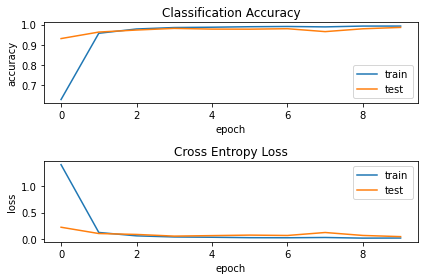

In [0]:
metrics_plot(cnn_model_1_history)

In [0]:
eval_model(cnn_model_1)

Test loss: 0.052999287843704224
Test accuracy: 98.5840380191803


#### CNN Model 1 Test Predictions ####

In [0]:
y_pred_cnn1 = cnn_model_1.predict(X_test)

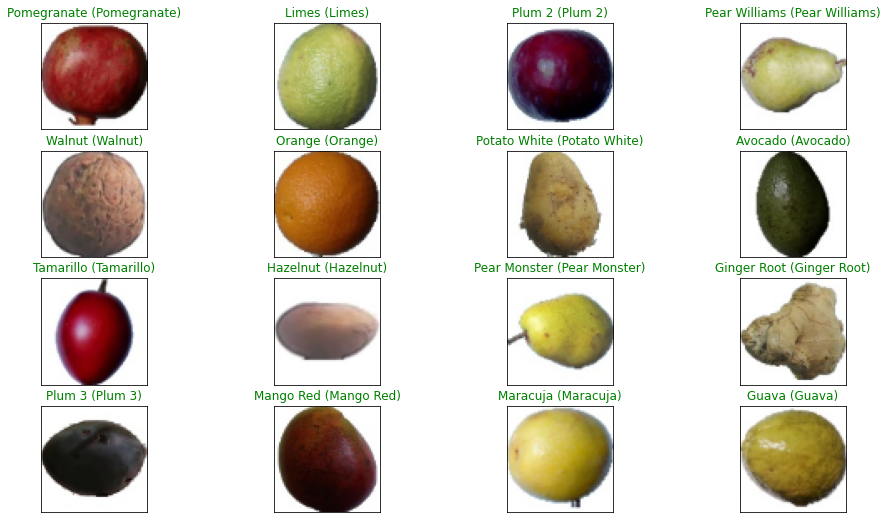

In [0]:
training_label2 = np.unique(training_label)
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred_cnn1[idx])
    true_idx = np.argmax(Y_test[idx])
    ax.set_title("{} ({})".format(training_label2[pred_idx], training_label2[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

fig

##Comparisons##

In [0]:
def compare_plot(model_hist1, model_hist2):
  # plotting the metrics
  fig = plt.figure()
  plt.subplot(2,1,1)
  plt.plot(model_hist1.history['accuracy'])
  plt.plot(model_hist1.history['val_accuracy'])
  plt.plot(model_hist2.history['accuracy'])
  plt.plot(model_hist2.history['val_accuracy'])
  plt.title('Classification Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_baseline', 'test_baseline','train_largermodel','test_largermodel'], loc='lower right')

  plt.subplot(2,1,2)
  plt.plot(model_hist1.history['loss'])
  plt.plot(model_hist1.history['val_loss'])
  plt.plot(model_hist2.history['loss'])
  plt.plot(model_hist2.history['val_loss'])
  plt.title('Cross Entropy Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_baseline', 'test_baseline','train_largermodel','test_largermodel'], loc='upper right')

  plt.tight_layout()

  return fig

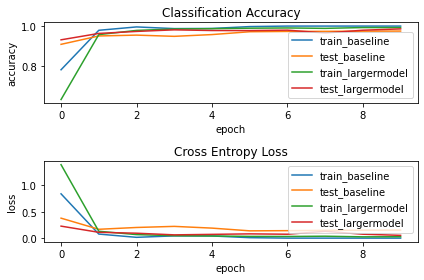

In [0]:
compare_plot(baseline_history,cnn_model_1_history)

In [0]:
baseline_score = baseline_model.evaluate(X_test, Y_test, verbose=0)
myCnnModel_score = cnn_model_1.evaluate(X_test, Y_test, verbose=0)

print('Baseline Test loss:', baseline_score[0])
print('My CNN Model Test loss:', myCnnModel_score[0])
print('Baseline Accuracy:', baseline_score[1]*100) 
print('My CNN Model Accuracy:', myCnnModel_score[1]*100) 

Baseline Test loss: 0.15414974093437195
My CNN Model Test loss: 0.052999287843704224
Baseline Accuracy: 97.48327136039734
My CNN Model Accuracy: 98.5840380191803


As we can see, the performance evaluation we will be doing is the score from .evaluate function. We have seen that my model has achieved over **98.58% accuray as well as a loss of 0.053** in approximate in comparison to the previous optimized model from the paper which has **0.154 loss and approximately 97.48% in accuracy**. 

####  Saving/ Loading Model to Disk ####

I saved my model to the disk so I could access it next time. 

In [0]:
#Save model to disk
def save_model(model):
  model_json = model.to_json()
  name_json = str(model) + ".json"
  with open(name_json, "w") as json_file:
      json_file.write(model_json)
  name_weight = str(model) + ".h5"
  model.save_weights(name_weight)
  print("CNN model saved to disk")

In [0]:
save_model(cnn_model_1)

CNN model saved to disk


In [0]:
# Load model from disk
def load_model(model):
  name_json = str(model) + ".json"
  json_file = open(name_json, 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  name_weight = str(model) + ".h5"
  loaded_model.load_weights(name_weight)
  print("CNN model loaded from disk")

#### CNN MODEL #2 ####

In [0]:
# Make Convolutional Neural Network
cnn_model_2 = my_model2()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 60, 60, 16)        1216      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 32)        12832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 64)       

In [0]:
# Compile and fit
cnn_model_2_history = cnn_model_2.fit(X_train,
          Y_train,
          batch_size=200,
          epochs=10,
          verbose=1,
          validation_data = (X_test,Y_test)
         )

Epoch 1/10
308/308 [==============================] - 9s 28ms/step - loss: 0.6374 - accuracy: 0.8286 - val_loss: 6.7502 - val_accuracy: 0.2016
Epoch 2/10
308/308 [==============================] - 8s 27ms/step - loss: 0.0832 - accuracy: 0.9734 - val_loss: 0.4361 - val_accuracy: 0.8924
Epoch 3/10
308/308 [==============================] - 9s 29ms/step - loss: 0.0449 - accuracy: 0.9856 - val_loss: 0.3655 - val_accuracy: 0.9127
Epoch 4/10
308/308 [==============================] - 9s 29ms/step - loss: 0.0457 - accuracy: 0.9868 - val_loss: 0.5237 - val_accuracy: 0.9022
Epoch 5/10
308/308 [==============================] - 12s 40ms/step - loss: 0.0281 - accuracy: 0.9922 - val_loss: 0.2913 - val_accuracy: 0.9304
Epoch 6/10
308/308 [==============================] - 8s 27ms/step - loss: 0.0436 - accuracy: 0.9873 - val_loss: 0.4749 - val_accuracy: 0.9086
Epoch 7/10
308/308 [==============================] - 8s 27ms/step - loss: 0.0294 - accuracy: 0.9919 - val_loss: 0.1241 - val_accuracy: 0.974

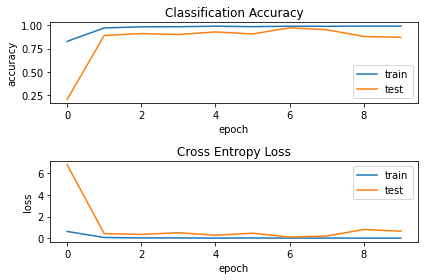

In [0]:
metrics_plot(cnn_model_2_history)

In [0]:
eval_model(cnn_model_2)

Test loss: 0.6546148061752319
Test accuracy: 87.21753358840942


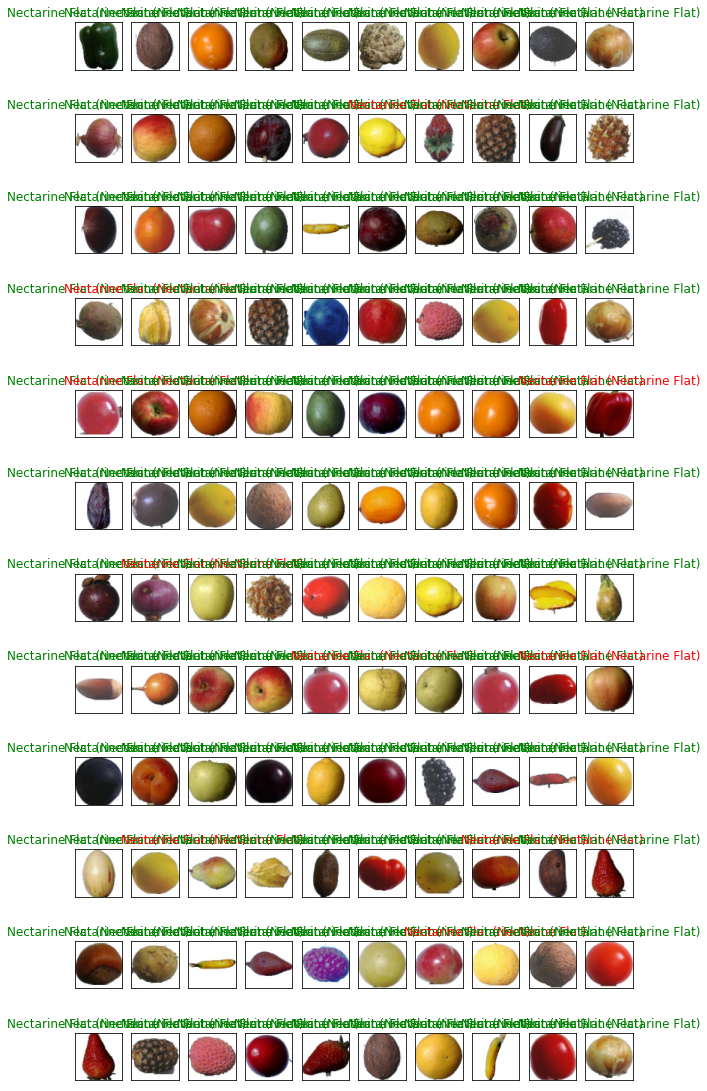

In [0]:
y_pred_cnn2 = cnn_model_2.predict(X_test)
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(10,20))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=120, replace=True)):
    ax = fig.add_subplot(12, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred_cnn2[idx])
    true_idx = np.argmax(Y_test[idx])
    ax.set_title("{} ({})".format(training_label[pred_idx], training_label[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

fig

In [0]:
import pandas as pd
y_predicTry = cnn_model_1.predict(X_test)

In [0]:
res_crosstab = pd.crosstab(y_predicTry, Y_test)

dict_idx_fruit = {idx: label for idx, label in enumerate(validation_label)}
print(dict_idx_fruit)

res_crosstab

ValueError: ignored